# <center> Introduction to Reinforcement Learning</center>

# Activity 0. Setup

#### Install additional dependencies

Let us first make sure that all the required dependencies are installed

In [ ]:
#removing this while developing the notebook from drive
#!git clone https://github.com/rvss-australia/RVSS.git

Cloning into 'RVSS'...
remote: Enumerating objects: 1239, done.
remote: Counting objects: 100% (341/341), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 1239 (delta 185), reused 280 (delta 135), pack-reused 898
Receiving objects: 100% (1239/1239), 173.52 MiB | 26.78 MiB/s, done.
Resolving deltas: 100% (615/615), done.
Updating files: 100% (259/259), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/projects/RVSS

Mounted at /content/drive
/content/drive/MyDrive/projects/RVSS


In [2]:
import os
print(os.getcwd())
os.chdir("Reinforcement_Learning/")

/content/drive/MyDrive/projects/RVSS


In [3]:
import sys
!{sys.executable} -m pip install gymnasium

#### Import dependencies

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle

import sys
import os

from RL_Support.gym_simple_gridworlds.helper import *
from RL_Support.gym_simple_gridworlds.envs.grid_env import GridEnv
from RL_Support.gym_simple_gridworlds.envs.grid_2dplot import *


from IPython.display import display, HTML

# Activity 1. Rewards for an MDP (Grid World Example)

Recall the grid in which our robot lives

![GridWorldExample.png](https://i.postimg.cc/5tMM5vqf/Grid-World-Example.png)

- The states $s \in \mathcal{S}$ correspond to locations in the grid. Each location has also a cell index associated to it, e.g., cell index 4 is associated to location (row=1,col=0)
- The robot can move up, down, left, or right. Actions correpond to unit increments or decrements in the specified direction.
    - Up : (-1,0)
    - Down: (1,0)
    - Left: (0,-1)
    - Right: (0, 1)
- Each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3. No actions are available at a terminal state

In [5]:
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)


### Living Reward and Reward Function

Let's now take a quick look at the living reward (i.e., running cost) and reward function $\mathcal{R}: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$.

1. Living reward corresponds to the attribute ``living_rewards`` of the class ``GridEnv`` and is represented as an 1-Dimensional numpy array
2. The reward function corresponds to the attribute ``rewards`` of the class ``GridEnv`` and is also represented as a 2-Dimensional numpy array of size $11\times4$

In [6]:
# Living rewards
print("Living rewards for all states:\n{}\n".format(grid_world.immediate_rewards))

# Reward function, i.e., expected reward for taking action a at state s
print("Reward function for all state-action pairs:\n{}\n".format(grid_world.rewards))
print("The expected reward at state 5 if agent chooses to move right is: {}".format(grid_world.rewards[5,3]))

Living rewards for all states:
[-0.04 -0.04 -0.04  1.   -0.04 -0.04 -1.   -0.04 -0.04 -0.04 -0.04]

Reward function for all state-action pairs:
[[-0.04  -0.04  -0.04  -0.04 ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [ 0.064  0.064 -0.04   0.792]
 [ 0.     0.     0.     0.   ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.136 -0.136 -0.04  -0.808]
 [ 0.     0.     0.     0.   ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.808 -0.04  -0.136 -0.136]]

The expected reward at state 5 if agent chooses to move right is: -0.808


# Activity 2. Iterative Policy Evaluation

Recall the definition of the iterative policy evaluation algorithm

![IterativePolicyEvaluation.png](https://i.postimg.cc/MGbJ9TdV/Iterative-Policy-Evaluation.png)

Let's now compute the value function of the same policy $\pi$

![example_policy.png](https://i.postimg.cc/pLjHnkj0/example-policy.png)

We consider a grid world environment with the following attributes:
- Discount factor $\gamma = 0.9$ (class attribute ``gamma=0.9``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- A non-zero living cost and big rewards are obtained at terminal states (class attribute ``living_reward=-0.04``)

We have defined the helper function ``encode_policy()`` to encode the policy $\pi$ shown in the image above. The return variable ``policy_pi`` is a dictionary of dictionaries, where each element corresponds to the probability of selecting an action $a$ at a given state $s$

Keep in mind that each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3.

In [7]:
import numpy as np # Ensure numpy is imported
from RL_Support.gym_simple_gridworlds.envs.grid_env import GridEnv # Import GridEnv



grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)
policy_pi = encode_policy(grid_world)

print("Action probabilities at state 0 are:\n{}".format(policy_pi[0]))

Action probabilities at state 0 are:
defaultdict(<class 'float'>, {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0})


Given the policy $\pi$, let's now compute its state-value function using iterative policy evaluation by implementing Algorithm 1.

**Keep in Mind**: Correspondance between the mathematical notation and implemented code

|                         |                                                    |                 |
| ----------------------- | -------------------------------------------------- | --------------- |
|                         | **Variable/Attribute**                             | **Type**        |
| $\gamma$                | `grid_world.gamma`                                 | `float`         |
| $\mathcal{T}(s, a, s')$ | `grid_world.state_transitions[idx_s, idx_a, idx_s]`| `numpy` 3d-array|
| $\mathcal{R}(s, a)$     | `grid_world.rewards[idx_s, idx_a]`                 | `numpy` 2d-array|
| $\pi(a\vert s)$         | `policy_pi[idx_s][idx_a]`                          | `dict` of `dict`|
| $v_\pi(s)$              | `v[idx_s]`                                         | `dict`          |


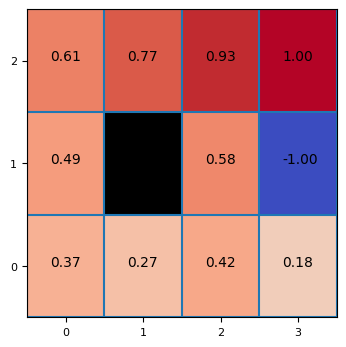

In [8]:
def policy_evaluation(grid_env, policy, plot=False, threshold=0.00001):

    """
    This function computes the value function for a policy pi in a given environment grid_env.

    :param grid_env (GridEnv): MDP environment
    :param policy (dict - stochastic form): Policy being evaluated
    :return: (dict) State-values for all non-terminal states
    """

    # Obtain list of all states in environment
    v = {s: 0.0 for s in grid_env.get_states()}
    theta = threshold
    delta = 1000

    while delta > theta:
        delta = 0.0
        # For all states
        for s in v.keys():

            old_v = v[s]
            new_v = 0

            # For all actions
            for a, probability_a in policy[s].items():
                discounted_v = 0

                # For all states that are reachable from s with action a
                for s_next in grid_env.get_states():

                    discounted_v += grid_env.state_transitions[s, a, s_next] * v[s_next]

                new_v += probability_a*(grid_env.rewards[s, a] + grid_env.gamma*discounted_v)

            v[s] = new_v
            delta = max(delta, np.abs(old_v - new_v))

    if plot:
        plot_value_function(grid_env, v)

    return v


# Call the policy evalution function
v = policy_evaluation(grid_world, policy_pi, plot=True)


Does changing the policy change the value?

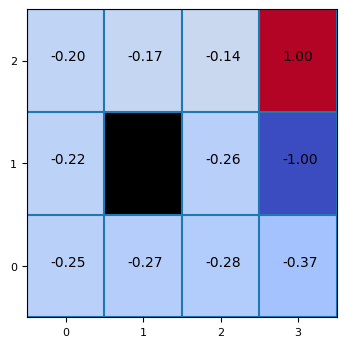

In [9]:
UP = 0; DOWN = 1; LEFT = 2; RIGHT = 3; STAY = np.nan

policy_matrix = np.array([[RIGHT, RIGHT,  DOWN,  STAY],
                          [UP,    STAY,   UP,     STAY],
                          [UP,    LEFT,   UP,     LEFT]])

policy_pi = encode_policy(grid_world, policy_matrix=policy_matrix)

v = policy_evaluation(grid_world, policy_pi, plot=True)


# Activity 3. Policy Iteration

Recall the definition of the policy iteration algorithm

![PolicyIteration.png](https://i.postimg.cc/26kRMDKJ/Policy-Iteration.png)

Starting with a random policy, let's find the optimal policy for a grid world environment with attributes:

We consider a grid world environment with the following attributes:
- Discount factor $\gamma = 0.9$ (class attribute ``gamma=0.9``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- Rewards are only obtained at terminal states (class attribute ``living_reward=-0.04``)

In `numpy`, there is a function called `argmax` where it returns the index of maximum value, for example `np.argmax([1,2,4,3])` will return `2`

Let's now define the policy iteration core algorithm.

The main steps of the policy iteration algoritm are:
- Use ``policy_evaluation(.)`` to compute the state-value function of a given policy
- Use ``update_policy(.)``  to obtain an updated policy


**Keep in mind:** $q_a = \mathcal{R}(s,a) + \gamma\sum_{s^\prime\in\mathcal{S}}\mathcal{T}(s, a, s^\prime)v_{\pi}(s^{\prime})$

In [10]:
def update_policy(grid_env, value_function_):
    """
    This function will update the input policy to the new policy with the input value_function

    : param grid_env (GridEnv): MDP environment
    : param value_function_ (dict): the value function that is used to generate policy
    : return (2D array): Updated Policy
    """
    non_terminal_states = grid_env.get_states(exclude_terminal=True)
    new_policy = np.full(grid_env.grid.shape, np.nan)
    for s in non_terminal_states:
        optimal_a = None
        list_of_q_a = []
        for a in grid_env.get_actions():
            discounted_value = 0
            for s_next in grid_env.get_states():
                 discounted_value += grid_env.state_transitions[s, a, s_next] * value_function_[s_next]
            # actually calculate q_a
            q_a = grid_env.rewards[s, a] + grid_env.gamma * discounted_value
            list_of_q_a.append(q_a)

        optimal_a = np.argmax(list_of_q_a)

        x, y = np.argwhere(grid_env.grid == s)[0]
        new_policy[x, y] = optimal_a

    return new_policy

In [11]:
def policy_iteration(grid_env, policy, plot=False):
    """
    This function iteratively updates a given policy pi for a given environment grid_env until convergence to optimal policy

    :param grid_env (GridEnv): MDP environment
    :param policy (matrix from): Deteministic policy being updated
    :return: (dict) State-values for all non-terminal states
    """
    prev_policy = np.zeros(policy.shape)

    while not np.array_equal(policy, prev_policy, equal_nan=True):

        # Encode policy. This policy representation is needed for policy evaluation
        encoded_policy = encode_policy(grid_env, policy)
        # Set prev_policy to current policy
        prev_policy = policy.copy()

        # 1. Evaluate the given policy (policy_evaluation expects an
        #    mdp and the enconded_policy as arguments)
        value_function = policy_evaluation(grid_env, encoded_policy)
        # 2. Update policy using function update_policy
        policy = update_policy(grid_env, value_function)
        # policy = update_policy(grid_env, policy, value_function)

    if plot:
        plot_policy(grid_env, policy)

    return policy


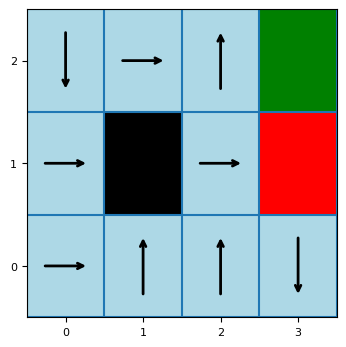

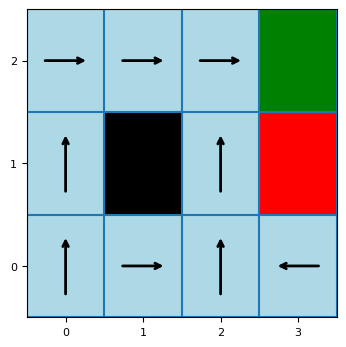

In [12]:
# Create a grid world mdp
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)

# Generate an initial random policy
initial_policy = define_random_policy(grid_world)
plot_policy(grid_world,initial_policy)

# Compute optimal policy using policy iteration
optimal_policy = policy_iteration(grid_world, initial_policy, plot=True)